In [1]:
# auto reload changes ipynb
# auto reload
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("/home/calvin/code/cmpnn_revised")
from typing import List
from cmpnn.featurizer.molecule_dataset import MultiMoleculeSDFDataset
from cmpnn.standardisation.mix_target_normalizer import MixedTargetNormalizer, BaseNormalizer, LogNormalizer, PeriodicNormalizer
from cmpnn.featurizer.atom_bond import AtomFeaturizer, BondFeaturizer
from cmpnn.featurizer.global_feat import CompositeGlobalFeaturizer, MorganBinaryFeaturizer, RDKit2DNormalizedFeaturizer
from cmpnn.split.kennardstone import KennardStoneSplitter
from torch.utils.data import DataLoader
from cmpnn.data.collate import multimol_collate_fn
from cmpnn.models.lightning import MultiCMPNNLightningModule
from cmpnn.optimizer.noam import NoamLikeOptimizer
from cmpnn.data.target import TargetSpec
from cmpnn.standardisation.electromap_normalizer import ElectromapNormalizer
import torch
import torchmetrics
import pytorch_lightning as pl



In [2]:
sdf_files = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/"
input_type = ["r1h", "r2h"]
target_data = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv"
target_columns = ["psi_1_dihedral"]
target_kinds = ["periodic"] # Radius, Radius, Angle are continuous whilst Dihedral are periodic (0-360 degrees range -> convert to cosine/sine)

In [3]:
normalizers = [
    PeriodicNormalizer()
]
normalizer = MixedTargetNormalizer(kinds=target_kinds,
                                   normalizers=normalizers)
atom_normalizer = ElectromapNormalizer()


m_dataset = MultiMoleculeSDFDataset(
    sdf_files=sdf_files,
    input_type=input_type,
    target_data=target_data,
    target_columns=target_columns,
    atom_featurizer=AtomFeaturizer(v2=True),
    bond_featurizer=BondFeaturizer(),
    atom_messages=True,
    use_cache=False,
    normalizer=normalizer,
    atom_feature_normalizer=atom_normalizer,
    use_electro_map=True,
    # global_featurizer=CompositeGlobalFeaturizer(
    #     featurizers=[
    #         MorganBinaryFeaturizer(radius=2),
    #         RDKit2DNormalizedFeaturizer(),
    #     ]
    # )
)


Processing and caching dataset to /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/sdf_folder_cache.pt
Target data for reaction 'rxn_288' not found in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_288.sdf.
Target data for reaction 'rxn_635' not found in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_635.sdf.
Target data for reaction 'rxn_785' not found in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_785.sdf.


In [4]:
m_dataset[0][0].y

tensor([353.8592])

In [5]:
print("Number of molecules in dataset: ", len(m_dataset))

Number of molecules in dataset:  1807


In [6]:
m_dataset[0]

[MoleculeData(f_atoms=[8, 83], f_bonds=[14, 14], a2b=[8], b2a=[14], a_scope=[1], b_scope=[1], y=[1], bonds=[7, 2], smiles='[H]OC(=C=O)C([H])=O', b2revb=[14], name='kfir_rxn_10218_r1h', comp_type='donor', idx=0),
 MoleculeData(f_atoms=[7, 83], f_bonds=[14, 14], a2b=[7], b2a=[14], a_scope=[1], b_scope=[1], y=[1], bonds=[7, 2], smiles='[H]C1([H])OC1([H])[H]', b2revb=[14], name='kfir_rxn_10218_r2h', comp_type='acceptor', idx=0)]

In [7]:
def check_feature_variance(dataset):
    for i, (donor, acceptor) in enumerate(dataset):
        donor_features = donor.f_atoms
        acceptor_features = acceptor.f_atoms
        print(f"Sample {i} - Donor: mean {donor_features.mean().item():.4f}, std {donor_features.std().item():.4f}")
        print(f"Sample {i} - Acceptor: mean {acceptor_features.mean().item():.4f}, std {acceptor_features.std().item():.4f}")

check_feature_variance(m_dataset[:10])


Sample 0 - Donor: mean 1.0646, std 11.3712
Sample 0 - Acceptor: mean 0.6732, std 6.5360
Sample 1 - Donor: mean 0.9806, std 9.4655
Sample 1 - Acceptor: mean 1.0134, std 10.9685
Sample 2 - Donor: mean 0.9597, std 10.1729
Sample 2 - Acceptor: mean 0.8289, std 8.9455
Sample 3 - Donor: mean 1.0524, std 10.1545
Sample 3 - Acceptor: mean 0.8322, std 9.0146
Sample 4 - Donor: mean 1.1392, std 11.2162
Sample 4 - Acceptor: mean 0.7910, std 7.7848
Sample 5 - Donor: mean 0.8996, std 8.6758
Sample 5 - Acceptor: mean 0.8320, std 8.2079
Sample 6 - Donor: mean 0.7306, std 7.0069
Sample 6 - Acceptor: mean 0.9775, std 10.2312
Sample 7 - Donor: mean 1.1204, std 11.6570
Sample 7 - Acceptor: mean 1.1364, std 10.8050
Sample 8 - Donor: mean 0.9006, std 8.6678
Sample 8 - Acceptor: mean 0.6869, std 7.2078
Sample 9 - Donor: mean 1.0239, std 9.9457
Sample 9 - Acceptor: mean 0.7953, std 7.8723


In [8]:
def compute_feature_variance(dataset):
    all_features = []
    for donor, acceptor in dataset:
        all_features.append(donor.f_atoms)
        all_features.append(acceptor.f_atoms)
    all_features = torch.cat(all_features, dim=0)
    return all_features.var(dim=0)

feature_variances = compute_feature_variance(m_dataset)
print(feature_variances)


tensor([2.3680e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1104e-01,
        2.5136e-02, 3.4441e-02, 2.4990e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9383e-02, 9.1567e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3235e-01, 8.0747e-02, 8.9987e-02,
        1.4667e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3317e-04, 3.3317e-04,
        0.0000e+00, 6.6611e-04, 0.0000e+00, 5.8258e-03, 3.5423e-03, 2.2999e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.3680e-01, 3.0997e-02, 1.1513e-01, 0.0000e+00,
        1.7177e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1101e-02, 4.5738e-03,
        4.7668e-02, 4.7668e-02, 4.7668e-

In [9]:
# Check that the first molecule pair have marked heavy and hydrogen acceptors and donors
last_4_names = ["acceptor", "a_hydrogen", "donator", "d_hydrogen"]
l4_cols = m_dataset[0][0].f_atoms[:, 133:137].numpy()
l4_cols = m_dataset[0][0].f_atoms[:, 133:137].numpy()
# Print header
print("Molecule Type: ", m_dataset[0][0].comp_type)
print(' | '.join(f'{name:^10}' for name in last_4_names))
print('-' * 50)
for row in l4_cols:
    print(' | '.join(f'{val:10.3f}' for val in row))

l4_cols = m_dataset[0][1].f_atoms[:, 133:137].numpy()
# Print header
print("Molecule Type: ", m_dataset[0][1].comp_type)
print(' | '.join(f'{name:^10}' for name in last_4_names))
print('-' * 50)
for row in l4_cols:
    print(' | '.join(f'{val:10.3f}' for val in row))


Molecule Type:  donor
 acceptor  | a_hydrogen |  donator   | d_hydrogen
--------------------------------------------------








Molecule Type:  acceptor
 acceptor  | a_hydrogen |  donator   | d_hydrogen
--------------------------------------------------









In [10]:
# Check that the first molecule pair have marked heavy and hydrogen acceptors and donors
last_4_names = ["R", "A", "Dsin", "Dcos", "has_R", "has_A", "has_D"]
l4_cols = m_dataset[0][0].f_atoms[:, -7:].numpy()
# Print header
print("Molecule Type: ", m_dataset[0][0].comp_type)
print(' | '.join(f'{name:^10}' for name in last_4_names))
print('-' * 50)
for row in l4_cols:
    print(' | '.join(f'{val:10.3f}' for val in row))

l4_cols = m_dataset[0][1].f_atoms[:, -7:].numpy()
# Print header
print("Molecule Type: ", m_dataset[0][1].comp_type)
print(' | '.join(f'{name:^10}' for name in last_4_names))
print('-' * 50)
for row in l4_cols:
    print(' | '.join(f'{val:10.3f}' for val in row))


Molecule Type:  donor
    R      |     A      |    Dsin    |    Dcos    |   has_R    |   has_A    |   has_D   
--------------------------------------------------
     0.800 |      0.000 |      0.000 |      1.000 |      1.000 |      0.000 |      0.000
     1.335 |    109.393 |      0.000 |      1.000 |      1.000 |      1.000 |      0.000
     1.348 |    120.822 |     -0.999 |     -0.040 |      1.000 |      1.000 |      1.000
     1.146 |    178.105 |      1.000 |     -0.014 |      1.000 |      1.000 |      1.000
     3.413 |     22.407 |      0.999 |      0.035 |      1.000 |      1.000 |      1.000
     1.206 |    163.758 |      0.206 |      0.979 |      1.000 |      1.000 |      1.000
     2.021 |     27.879 |      0.206 |     -0.978 |      1.000 |      1.000 |      1.000
     0.000 |      0.000 |      0.000 |      1.000 |      0.000 |      0.000 |      0.000
Molecule Type:  acceptor
    R      |     A      |    Dsin    |    Dcos    |   has_R    |   has_A    |   has_D   
------------

In [11]:
splitter = KennardStoneSplitter(seed=42, component='joint', distance_mode='mean', distance_metric='euclidean')


In [12]:
train_ds, val_ds, test_ds, train_idx, val_idx, test_idx, order = splitter.split(
    dataset=m_dataset,
    train_frac=0.6,
    val_frac=0.2,
    test_frac=0.2,
    return_indices=True,
    return_order=True,
)

Distance matrix shape: (1807, 1807)
Distance matrix min/max: 0.0 471.3003
Distance matrix diagonal: [0.0000000e+00 0.0000000e+00 2.6973983e-06 1.9073486e-06 1.9073486e-06
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [13]:
# from cmpnn.split.random import RandomSplitter
# splitter = RandomSplitter(seed=42)
# train_ds, val_ds, test_ds, train_idx, val_idx, test_idx, order = splitter.split(
#     dataset=m_dataset,
#     train_frac=0.6,
#     val_frac=0.2,
#     test_frac=0.2,
#     return_indices=True,
#     return_order=True,
# )

In [14]:
print("dataset fitted?", m_dataset.normalizer_fitted)
m_dataset.fit_normalizer_from_indices(train_idx)

# Apply to all splits
m_dataset.transform_y_from_indices(train_idx + val_idx + test_idx)
print("dataset fitted?", m_dataset.normalizer_fitted)

dataset fitted? False
dataset fitted? True


In [15]:
print(m_dataset[0][0].y)
print(m_dataset[0][1].y)

tensor([-0.1070,  0.9943])
tensor([-0.1070,  0.9943])


In [16]:
m_dataset.fit_atom_feature_normalizer_from_indices(train_idx)
m_dataset.transform_all_f_atoms()

In [17]:
train_ds[0][0].f_atoms[:, -7:]

tensor([[-0.5682,  0.6633,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000],
        [-1.2664,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.9720,  1.5800, -0.0403,  0.9992,  1.0000,  1.0000,  1.0000],
        [-0.3052, -1.2589, -0.8463, -0.5328,  1.0000,  1.0000,  1.0000],
        [-0.3064, -0.5856, -0.6161,  0.7877,  1.0000,  1.0000,  1.0000],
        [ 1.0235, -0.7279,  0.9377,  0.3476,  1.0000,  1.0000,  1.0000],
        [-0.2595, -0.7358,  0.0305, -0.9995,  1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000]])

In [18]:
test_ds[0][0].f_atoms[:, -7:]

tensor([[-1.2664,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.5902,  1.0503,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000],
        [-0.5332,  0.7628,  0.9475, -0.3198,  1.0000,  1.0000,  1.0000],
        [ 1.1208, -1.1049, -0.4155,  0.9096,  1.0000,  1.0000,  1.0000],
        [ 1.0081, -1.1528,  0.2959,  0.9552,  1.0000,  1.0000,  1.0000],
        [-0.3104, -0.7154, -0.9556,  0.2947,  1.0000,  1.0000,  1.0000],
        [ 0.9918, -0.7563,  0.9711,  0.2387,  1.0000,  1.0000,  1.0000],
        [-0.2986, -0.7056, -0.0052, -1.0000,  1.0000,  1.0000,  1.0000],
        [-0.3011, -0.5831, -0.9066,  0.4221,  1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000]])

In [19]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

bins = np.linspace(-180, +180, 37)

# Get the y values from train_ds
y_train = []
for datapoint in train_ds:
    molecule = datapoint[0]  # assuming first molecule in multimol
    cos_val, sin_val = molecule.y[0], molecule.y[1]
    y_train.append((cos_val, sin_val))
y_train = torch.tensor(y_train)

# Change y train to theta
# Now need to transform the y_train (cos, sin) to the degrees
theta_train = torch.atan2(y_train[:, 1], y_train[:, 0])  # in radians
theta_train = torch.rad2deg(theta_train)  # convert to degrees
# Wrap into [-180, 180]
theta_train = (theta_train + 180) % 360 - 180

bin_ids = np.digitize(theta_train, bins) - 1  # 0..35

# count samples per bin
counts = np.bincount(bin_ids, minlength=len(bins)-1)
# avoid div0
counts = np.where(counts==0, 1, counts)
# weight = 1/count → normalize
weights = 1.0 / counts[bin_ids]
weights = torch.as_tensor(weights, dtype=torch.double)

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(
    train_ds,
    batch_size=128,
    sampler=sampler,
    collate_fn=multimol_collate_fn
)

In [20]:
#train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=multimol_collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=multimol_collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=multimol_collate_fn)

In [21]:
# Select 40 data points from the training set
# train_ds_small = torch.utils.data.Subset(train_ds, range(200))

# train_loader = DataLoader(train_ds_small, batch_size=32, shuffle=True, collate_fn=multimol_collate_fn)
# theta_true_list = []
# for datapoint in train_ds_small:
#     molecule = datapoint[0]  # assuming first molecule in pair
#     cos_val, sin_val = molecule.y[0], molecule.y[1]
#     theta = torch.atan2(sin_val, cos_val)  # recover angle in radians
#     theta_true_list.append(theta)

# # Stack them into a tensor
# theta_true = torch.stack(theta_true_list)  # shape (40,)

# # import numpy as np
# import torch
# import copy

# # Generate clean base angles
# theta_true = torch.linspace(-np.pi, np.pi, steps=40)  # 20 torsions

# # # 🔥 ADD JIGGLES HERE 🔥
# # theta_true += (10 * np.pi / 180) * torch.randn_like(theta_true)

# # Augment: add +360 deg equivalents
# theta_true_aug = torch.cat([
#     theta_true,
#     theta_true + 2 * np.pi
# ], dim=0)
# theta_true_aug = (theta_true_aug + np.pi) % (2 * np.pi) - np.pi  # wrap into [-π, π]

# # Now generate cos/sin AFTER augmentation
# x_fake_aug = torch.stack([torch.cos(theta_true_aug), torch.sin(theta_true_aug)], dim=1)  # (40, 2)

# # Rebuild bigger fake dataset
# augmented_train_ds = []
# for i in range(len(x_fake_aug)):
#     datapoint = train_ds[i]

#     new_datapoint = copy.deepcopy(datapoint)
#     for molecule in new_datapoint:
#         molecule.y = x_fake_aug[i]  # Assign fake torsion
#     augmented_train_ds.append(new_datapoint)

# # New DataLoader
# train_loader = DataLoader(augmented_train_ds, batch_size=16, shuffle=False, collate_fn=multimol_collate_fn)


In [22]:
theta_true_list = []
for datapoint in train_ds:
    molecule = datapoint[0]  # assuming first molecule in multimol
    cos_val, sin_val = molecule.y[0], molecule.y[1]
    theta = torch.atan2(sin_val, cos_val)  # in radians
    theta_true_list.append(theta)

theta_true = torch.tensor(theta_true_list)


In [23]:
len(theta_true)

1084

In [24]:
# from torch.utils.data import random_split

# # Split 75% train, 25% val
# train_size = int(0.75 * len(train_ds_small))
# val_size = len(train_ds_small) - train_size
# train_ds_split, val_ds_split = random_split(train_ds_small, [train_size, val_size])

# # For curriculum jiggle: recover base torsions for train only
# theta_true_list = []
# for datapoint in train_ds_split:
#     molecule = datapoint[0]  # assuming first molecule in multimol
#     cos_val, sin_val = molecule.y[0], molecule.y[1]
#     theta = torch.atan2(sin_val, cos_val)  # in radians
#     theta_true_list.append(theta)

# theta_true = torch.tensor(theta_true_list)

# # New DataLoaders
# train_loader = DataLoader(train_ds_split, batch_size=32, shuffle=True, collate_fn=multimol_collate_fn)
# val_loader = DataLoader(val_ds_split, batch_size=32, shuffle=False, collate_fn=multimol_collate_fn)


In [25]:
for batch in train_loader:
    for donor_idx, acceptor_idx in zip(batch.donor.idx, batch.acceptor.idx):
        assert donor_idx == acceptor_idx, f"Mismatch: donor {donor_idx} vs acceptor {acceptor_idx}"
        print(f"Matching donor and acceptor indices: {donor_idx}")
    break  # Just to check the first batch


Matching donor and acceptor indices: 0
Matching donor and acceptor indices: 1
Matching donor and acceptor indices: 2
Matching donor and acceptor indices: 3
Matching donor and acceptor indices: 4
Matching donor and acceptor indices: 5
Matching donor and acceptor indices: 6
Matching donor and acceptor indices: 7
Matching donor and acceptor indices: 8
Matching donor and acceptor indices: 9
Matching donor and acceptor indices: 10
Matching donor and acceptor indices: 11
Matching donor and acceptor indices: 12
Matching donor and acceptor indices: 13
Matching donor and acceptor indices: 14
Matching donor and acceptor indices: 15
Matching donor and acceptor indices: 16
Matching donor and acceptor indices: 17
Matching donor and acceptor indices: 18
Matching donor and acceptor indices: 19
Matching donor and acceptor indices: 20
Matching donor and acceptor indices: 21
Matching donor and acceptor indices: 22
Matching donor and acceptor indices: 23
Matching donor and acceptor indices: 24
Matching d

In [26]:
theta_true.shape

torch.Size([1084])

In [27]:
train_ds[0]

[MoleculeData(f_atoms=[8, 83], f_bonds=[14, 14], a2b=[8], b2a=[14], a_scope=[1], b_scope=[1], y=[2], bonds=[7, 2], smiles='[H]C([H])([H])C([H])([H])[H]', b2revb=[14], name='rxn_1523_r1h', comp_type='donor', idx=1051),
 MoleculeData(f_atoms=[21, 83], f_bonds=[42, 14], a2b=[21], b2a=[42], a_scope=[1], b_scope=[1], y=[2], bonds=[21, 2], smiles='[H]c1c([H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]', b2revb=[42], name='rxn_1523_r2h', comp_type='acceptor', idx=1051)]

In [76]:
from cmpnn.models.lightning import MultiCMPNNLightningModuleClean
from cmpnn.models.ffns import LogGaussianHead, PeriodicHead, AngularHuberHead, MLP, DeepPeriodicHead
from cmpnn.loss.composite_loss import CompositeLoss
from cmpnn.loss.periodic_loss import PeriodicLossMAE, PeriodicLossRMSE, PeriodicLossMSE, PeriodicLossR2, AngularHuberLoss, PeriodicLossVonMises, AngleMAELoss, HybridAngularLoss, PureCosineLoss
from cmpnn.loss.continous_loss import ContinuousLossMAE, ContinuousLossRMSE, ContinuousLossMSE, ContinuousLossR2
import torch

torch.cuda.empty_cache()  # If you were using CUDA
torch._C._cuda_emptyCache()  # Sometimes frees more aggressively (works in HIP/ROCm as well)

torch.cuda.ipc_collect()

model = MultiCMPNNLightningModuleClean(
    atom_fdim=83,
    bond_fdim=14,
    global_fdim=0,
    shared_encoder=True,
    booster='sum',
    comm_mode='add',
    aggregator='mean',
    n_components=2,
    atom_messages=True,
    depth=2,
    output_size=1,
    hidden_dim=64,
    dropout=0.3,
    activation='relu',
    bias=False,
    optimizer_class=torch.optim.AdamW,
    optimizer_params={"weight_decay": 1e-2},
learning_rate=1e-6,
    dynamic_depth=None,
    use_atom_residual=False,
    use_bond_residual=True,
    metrics=[PureCosineLoss(), HybridAngularLoss(),AngleMAELoss(boost_threshold_deg=90, boost_weight=2.0),AngularHuberLoss(beta=5.0, unit_weight=0.01), PeriodicLossMSE(),PeriodicLossMAE(), PeriodicLossRMSE(), PeriodicLossMSE(), PeriodicLossR2()],
    ignore_value=-10,
    target_normalizer=normalizer,
    per_indices=[0,1],
    scaled_output=False,
    ffns= 
            #lambda input_dim: PeriodicHead(input_dim=input_dim, hidden_dim=300, n_layers=2, dropout=0.5, use_residual=True),
            lambda input_dim: DeepPeriodicHead(input_dim=input_dim, hidden_dim=2048, n_blocks=10, dropout=0.3),
    use_batch_norm=True,
    base_train_ds=train_ds,
    theta_true_aug=theta_true,
    apply_bottleneck=False,
    adaptive_jiggle=False,

)
    
    # focus_target_idx=2
print(model)

MultiCMPNNLightningModuleClean(
  (atom_feature_bottleneck): Identity()
  (encoders): ModuleList(
    (0-1): 2 x CMPNNEncoder(
      comm_mode=add, booster=sum
        (dropout_layer): Dropout(p=0.3, inplace=False)
        (act_func): ReLU()
        (W_i_atom): Linear(in_features=83, out_features=64, bias=False)
        (W_i_bond): Linear(in_features=14, out_features=64, bias=False)
        (W_o): Linear(in_features=128, out_features=64, bias=False)
        (lr): Linear(in_features=192, out_features=64, bias=False)
        (gru): BatchGRU(
          (gru): GRU(64, 64, batch_first=True, bidirectional=True)
        )
        (bn_atom): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn_bond): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (W_h_bn): ModuleList(
          (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
  )
  (bond_projections): ModuleList

In [77]:
def reset_model_weights(model):
    for module in model.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

reset_model_weights(model)

In [78]:
val_ds[0][0].y

tensor([-0.2963,  0.9551])

In [79]:
model.mol_to_reaction_idx

tensor([   0,    0,    1,  ..., 1082, 1083, 1083])

In [80]:
torch.cuda.empty_cache()  # If you were using CUDA

In [81]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.profilers import AdvancedProfiler
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32   = True

logger = CSVLogger(
    save_dir="logs",
    name="multi_cmpnn",            # creates logs/multi_cmpnn/{version}
)

trainer = pl.Trainer(
    max_epochs=1500,
    accelerator='gpu',
    devices=1,
    logger=logger,
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            dirpath="checkpoints/",
            filename="best_model",
            save_on_train_epoch_end=False,
        ),
        # weight_cb,

        pl.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=40,
            mode="min",
        ),
    
    ],
    log_every_n_steps=20,
    gradient_clip_val=1.0,
    gradient_clip_algorithm='norm',
    # precision=16, 
profiler="simple",
)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:45: Attribute 'ffns' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['ffns'])`.
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/calvin/code/cmpnn_revised/scripts/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type             | Params | Mode 
---------------------------------------------------------------------
0 | atom_feature_bottleneck | Identity         | 0      | train
1 | encoders                | ModuleList       | 77.1 K | train
2 | bond_projections        | ModuleList       | 18.6 K | train
3 | aggregator              | MeanAggregator   | 0      | train
4 | bn                      | BatchNorm1d      | 256    | train
5 | ffn         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

[DEBUG] Train targets sample (epoch 0): tensor([[ 0.8454,  0.5341],
        [ 0.2842, -0.9588],
        [-0.6175,  0.7866],
        [-0.9891,  0.1473],
        [-0.9957,  0.0924]], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

Bin -180.0→-170.0: MAE=312.11°  (n=17)
Bin -170.0→-160.0: MAE=300.91°  (n=14)
Bin -160.0→-150.0: MAE=288.81°  (n=6)
Bin -150.0→-140.0: MAE=277.63°  (n=5)
Bin -140.0→-130.0: MAE=269.24°  (n=36)
Bin -130.0→-120.0: MAE=259.11°  (n=11)
Bin -120.0→-110.0: MAE=249.27°  (n=10)
Bin -110.0→-100.0: MAE=238.75°  (n=15)
Bin -100.0→ -90.0: MAE=230.21°  (n=8)
Bin  -90.0→ -80.0: MAE=217.30°  (n=5)
Bin  -80.0→ -70.0: MAE=208.48°  (n=11)
Bin  -70.0→ -60.0: MAE=198.39°  (n=15)
Bin  -60.0→ -50.0: MAE=190.06°  (n=12)
Bin  -50.0→ -40.0: MAE=179.48°  (n=10)
Bin  -40.0→ -30.0: MAE=167.65°  (n=17)
Bin  -30.0→ -20.0: MAE=159.95°  (n=22)
Bin  -20.0→ -10.0: MAE=150.73°  (n=18)
Bin  -10.0→   0.0: MAE=137.37°  (n=38)
Bin    0.0→  10.0: MAE=131.52°  (n=38)
Bin   10.0→  20.0: MAE=119.91°  (n=12)
Bin   20.0→  30.0: MAE=107.12°  (n=13)
Bin   30.0→  40.0: MAE=100.48°  (n=23)
Bin   40.0→  50.0: MAE=85.92°  (n=6)
Bin   50.0→  60.0: MAE=79.42°  (n=12)
Bin   60.0→  70.0: MAE=70.33°  (n=17)
Bin   70.0→  80.0: MAE=59.79°  (n

/home/calvin/code/cmpnn_revised/cmpnn/models/cmpnn.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float32):


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 89.61° | >45° Errors: 824 | >90° Errors: 532


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.83° | >45° Errors: 836 | >90° Errors: 554


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 86.79° | >45° Errors: 786 | >90° Errors: 514


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 87.26° | >45° Errors: 779 | >90° Errors: 525


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 89.46° | >45° Errors: 814 | >90° Errors: 533


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 88.49° | >45° Errors: 804 | >90° Errors: 549


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 92.13° | >45° Errors: 824 | >90° Errors: 552


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 89.26° | >45° Errors: 813 | >90° Errors: 530


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 89.86° | >45° Errors: 825 | >90° Errors: 539
[DEBUG] Train targets sample (epoch 10): tensor([[-0.4126,  0.9109],
        [-0.9998,  0.0223],
        [-0.7895,  0.6137],
        [ 0.9609, -0.2768],
        [ 0.9803,  0.1975]], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

Bin -180.0→-170.0: MAE=312.25°  (n=15)
Bin -170.0→-160.0: MAE=299.37°  (n=8)
Bin -160.0→-150.0: MAE=290.30°  (n=5)
Bin -150.0→-140.0: MAE=237.26°  (n=4)
Bin -140.0→-130.0: MAE=268.81°  (n=29)
Bin -130.0→-120.0: MAE=261.20°  (n=7)
Bin -120.0→-110.0: MAE=249.64°  (n=7)
Bin -110.0→-100.0: MAE=221.28°  (n=9)
Bin -100.0→ -90.0: MAE=230.74°  (n=5)
Bin  -90.0→ -80.0: MAE=219.08°  (n=4)
Bin  -80.0→ -70.0: MAE=196.10°  (n=8)
Bin  -70.0→ -60.0: MAE=199.30°  (n=11)
Bin  -60.0→ -50.0: MAE=190.66°  (n=10)
Bin  -50.0→ -40.0: MAE=158.88°  (n=8)
Bin  -40.0→ -30.0: MAE=168.44°  (n=12)
Bin  -30.0→ -20.0: MAE=157.74°  (n=16)
Bin  -20.0→ -10.0: MAE=150.92°  (n=13)
Bin  -10.0→   0.0: MAE=134.98°  (n=27)
Bin    0.0→  10.0: MAE=132.70°  (n=28)
Bin   10.0→  20.0: MAE=121.07°  (n=9)
Bin   20.0→  30.0: MAE=108.46°  (n=9)
Bin   30.0→  40.0: MAE=100.67°  (n=16)
Bin   40.0→  50.0: MAE=89.54°  (n=5)
Bin   50.0→  60.0: MAE=80.93°  (n=10)
Bin   60.0→  70.0: MAE=69.75°  (n=14)
Bin   70.0→  80.0: MAE=65.59°  (n=9)
Bin 

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.77° | >45° Errors: 817 | >90° Errors: 559


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.38° | >45° Errors: 820 | >90° Errors: 541


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 87.62° | >45° Errors: 790 | >90° Errors: 519


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 89.23° | >45° Errors: 796 | >90° Errors: 529


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 89.78° | >45° Errors: 804 | >90° Errors: 532


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 91.50° | >45° Errors: 834 | >90° Errors: 553


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 87.56° | >45° Errors: 800 | >90° Errors: 521


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.73° | >45° Errors: 791 | >90° Errors: 549


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.67° | >45° Errors: 814 | >90° Errors: 558
[DEBUG] Train targets sample (epoch 20): tensor([[ 4.8533e-01, -8.7433e-01],
        [ 5.4034e-05, -1.0000e+00],
        [-3.7259e-01, -9.2799e-01],
        [-6.0308e-01, -7.9768e-01],
        [ 7.9668e-01, -6.0440e-01]], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

Bin -180.0→-170.0: MAE=313.05°  (n=15)
Bin -170.0→-160.0: MAE=300.46°  (n=8)
Bin -160.0→-150.0: MAE=290.34°  (n=5)
Bin -150.0→-140.0: MAE=276.72°  (n=4)
Bin -140.0→-130.0: MAE=268.45°  (n=29)
Bin -130.0→-120.0: MAE=261.23°  (n=7)
Bin -120.0→-110.0: MAE=247.44°  (n=7)
Bin -110.0→-100.0: MAE=230.36°  (n=9)
Bin -100.0→ -90.0: MAE=230.82°  (n=5)
Bin  -90.0→ -80.0: MAE=219.22°  (n=4)
Bin  -80.0→ -70.0: MAE=181.84°  (n=8)
Bin  -70.0→ -60.0: MAE=199.31°  (n=11)
Bin  -60.0→ -50.0: MAE=188.57°  (n=10)
Bin  -50.0→ -40.0: MAE=158.95°  (n=8)
Bin  -40.0→ -30.0: MAE=168.40°  (n=12)
Bin  -30.0→ -20.0: MAE=155.46°  (n=16)
Bin  -20.0→ -10.0: MAE=150.59°  (n=13)
Bin  -10.0→   0.0: MAE=134.42°  (n=27)
Bin    0.0→  10.0: MAE=132.03°  (n=28)
Bin   10.0→  20.0: MAE=121.13°  (n=9)
Bin   20.0→  30.0: MAE=108.53°  (n=9)
Bin   30.0→  40.0: MAE=100.14°  (n=16)
Bin   40.0→  50.0: MAE=89.11°  (n=5)
Bin   50.0→  60.0: MAE=81.05°  (n=10)
Bin   60.0→  70.0: MAE=66.18°  (n=14)
Bin   70.0→  80.0: MAE=64.14°  (n=9)
Bin 

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 87.59° | >45° Errors: 778 | >90° Errors: 527


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.79° | >45° Errors: 809 | >90° Errors: 550


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 91.34° | >45° Errors: 831 | >90° Errors: 553


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 89.97° | >45° Errors: 825 | >90° Errors: 537


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.17° | >45° Errors: 817 | >90° Errors: 545


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 91.65° | >45° Errors: 819 | >90° Errors: 550


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 88.12° | >45° Errors: 791 | >90° Errors: 535


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 91.47° | >45° Errors: 813 | >90° Errors: 545


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 88.50° | >45° Errors: 802 | >90° Errors: 528
[DEBUG] Train targets sample (epoch 30): tensor([[ 0.0020,  1.0000],
        [ 0.9857, -0.1684],
        [ 0.4419,  0.8971],
        [-0.1971,  0.9804],
        [-0.9375,  0.3479]], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

Bin -180.0→-170.0: MAE=313.12°  (n=15)
Bin -170.0→-160.0: MAE=298.99°  (n=8)
Bin -160.0→-150.0: MAE=290.34°  (n=5)
Bin -150.0→-140.0: MAE=237.05°  (n=4)
Bin -140.0→-130.0: MAE=268.57°  (n=29)
Bin -130.0→-120.0: MAE=261.25°  (n=7)
Bin -120.0→-110.0: MAE=248.88°  (n=7)
Bin -110.0→-100.0: MAE=219.13°  (n=9)
Bin -100.0→ -90.0: MAE=230.61°  (n=5)
Bin  -90.0→ -80.0: MAE=218.87°  (n=4)
Bin  -80.0→ -70.0: MAE=198.52°  (n=8)
Bin  -70.0→ -60.0: MAE=199.43°  (n=11)
Bin  -60.0→ -50.0: MAE=189.83°  (n=10)
Bin  -50.0→ -40.0: MAE=157.26°  (n=8)
Bin  -40.0→ -30.0: MAE=168.17°  (n=12)
Bin  -30.0→ -20.0: MAE=156.09°  (n=16)
Bin  -20.0→ -10.0: MAE=149.61°  (n=13)
Bin  -10.0→   0.0: MAE=130.12°  (n=27)
Bin    0.0→  10.0: MAE=131.54°  (n=28)
Bin   10.0→  20.0: MAE=120.86°  (n=9)
Bin   20.0→  30.0: MAE=108.28°  (n=9)
Bin   30.0→  40.0: MAE=98.74°  (n=16)
Bin   40.0→  50.0: MAE=89.57°  (n=5)
Bin   50.0→  60.0: MAE=80.73°  (n=10)
Bin   60.0→  70.0: MAE=67.82°  (n=14)
Bin   70.0→  80.0: MAE=64.29°  (n=9)
Bin  

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 88.95° | >45° Errors: 806 | >90° Errors: 521


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.41° | >45° Errors: 818 | >90° Errors: 551


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 88.23° | >45° Errors: 802 | >90° Errors: 531


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 88.50° | >45° Errors: 815 | >90° Errors: 524


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 89.00° | >45° Errors: 796 | >90° Errors: 539


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.90° | >45° Errors: 820 | >90° Errors: 546


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 91.46° | >45° Errors: 832 | >90° Errors: 560


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 88.14° | >45° Errors: 808 | >90° Errors: 519


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.32° | >45° Errors: 820 | >90° Errors: 547
[DEBUG] Train targets sample (epoch 40): tensor([[ 0.7674, -0.6412],
        [ 0.9608, -0.2772],
        [-0.9535,  0.3015],
        [-0.2432,  0.9700],
        [-0.9892,  0.1466]], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

Bin -180.0→-170.0: MAE=313.25°  (n=15)
Bin -170.0→-160.0: MAE=298.35°  (n=8)
Bin -160.0→-150.0: MAE=290.37°  (n=5)
Bin -150.0→-140.0: MAE=236.98°  (n=4)
Bin -140.0→-130.0: MAE=267.67°  (n=29)
Bin -130.0→-120.0: MAE=261.30°  (n=7)
Bin -120.0→-110.0: MAE=249.63°  (n=7)
Bin -110.0→-100.0: MAE=221.87°  (n=9)
Bin -100.0→ -90.0: MAE=230.94°  (n=5)
Bin  -90.0→ -80.0: MAE=219.06°  (n=4)
Bin  -80.0→ -70.0: MAE=186.49°  (n=8)
Bin  -70.0→ -60.0: MAE=199.52°  (n=11)
Bin  -60.0→ -50.0: MAE=189.95°  (n=10)
Bin  -50.0→ -40.0: MAE=174.12°  (n=8)
Bin  -40.0→ -30.0: MAE=168.33°  (n=12)
Bin  -30.0→ -20.0: MAE=156.68°  (n=16)
Bin  -20.0→ -10.0: MAE=150.39°  (n=13)
Bin  -10.0→   0.0: MAE=134.39°  (n=27)
Bin    0.0→  10.0: MAE=131.77°  (n=28)
Bin   10.0→  20.0: MAE=120.76°  (n=9)
Bin   20.0→  30.0: MAE=108.02°  (n=9)
Bin   30.0→  40.0: MAE=99.99°  (n=16)
Bin   40.0→  50.0: MAE=89.09°  (n=5)
Bin   50.0→  60.0: MAE=80.93°  (n=10)
Bin   60.0→  70.0: MAE=69.67°  (n=14)
Bin   70.0→  80.0: MAE=64.00°  (n=9)
Bin  

Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 88.31° | >45° Errors: 821 | >90° Errors: 526


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 90.08° | >45° Errors: 813 | >90° Errors: 548


Validation: |          | 0/? [00:00<?, ?it/s]

[DEBUG] MAE: 87.45° | >45° Errors: 795 | >90° Errors: 504


Validation: |          | 0/? [00:00<?, ?it/s]

FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -       

[DEBUG] MAE: 88.93° | >45° Errors: 815 | >90° Errors: 531


In [82]:
# Get the y values from train_ds
y_train = []
for datapoint in train_ds:
    molecule = datapoint[0]  # assuming first molecule in multimol
    cos_val, sin_val = molecule.y[0], molecule.y[1]
    y_train.append((cos_val, sin_val))
y_train = torch.tensor(y_train)

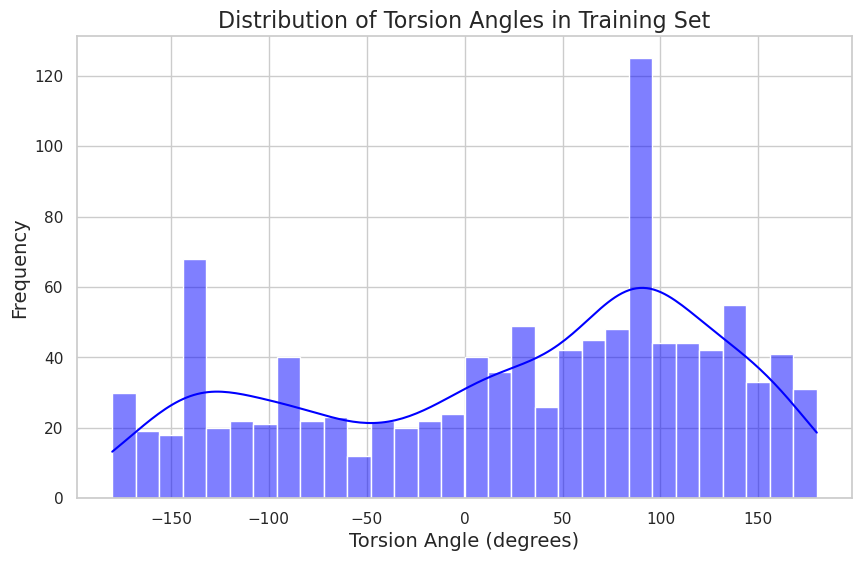

In [121]:
# Now need to transform the y_train (cos, sin) to the degrees
theta_train = torch.atan2(y_train[:, 1], y_train[:, 0])  # in radians
theta_train = torch.rad2deg(theta_train)  # convert to degrees
# Wrap into [-180, 180]
theta_train = (theta_train + 180) % 360 - 180

# Graph them 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Create a histogram
sns.histplot(theta_train.numpy(), bins=30, kde=True, color='blue', ax=ax)
# Set the title and labels
ax.set_title('Distribution of Torsion Angles in Training Set', fontsize=16)
ax.set_xlabel('Torsion Angle (degrees)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()

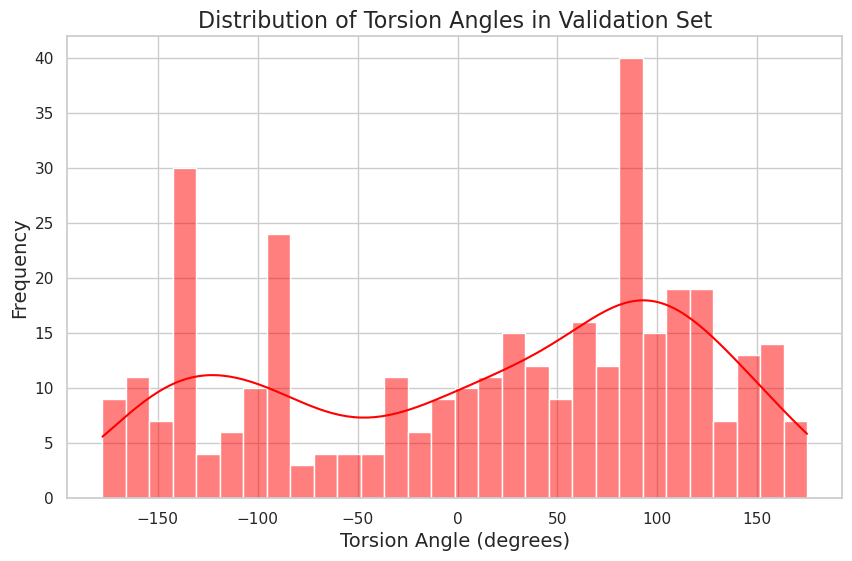

In [122]:
# Do the same for validation set
y_val = []
for datapoint in val_ds:
    molecule = datapoint[0]  # assuming first molecule in multimol
    cos_val, sin_val = molecule.y[0], molecule.y[1]
    y_val.append((cos_val, sin_val))

y_val = torch.tensor(y_val)

# Now need to transform the y_val (cos, sin) to the degrees
theta_val = torch.atan2(y_val[:, 1], y_val[:, 0])  # in radians
theta_val = torch.rad2deg(theta_val)  # convert to degrees
# Wrap into [-180, 180]
theta_val = (theta_val + 180) % 360 - 180
# Graph them
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Create a histogram
sns.histplot(theta_val.numpy(), bins=30, kde=True, color='red', ax=ax)
# Set the title and labels
ax.set_title('Distribution of Torsion Angles in Validation Set', fontsize=16)
ax.set_xlabel('Torsion Angle (degrees)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
# Show the plot
plt.show()

In [123]:
import numpy as np

# assume you have two 1-D numpy arrays of shape (N,)
#   train_angles_deg – all the true torsion angles (in degrees) used to *train* on
#   val_angles_deg   – all the true torsion angles (in degrees) held out for *validation*

# 1) choose your bin edges
bins = np.linspace(-180, +180, 37)   # 10° bins

# 2) histogram each
train_counts, _ = np.histogram(theta_train, bins=bins)
val_counts,   _ = np.histogram(theta_val,   bins=bins)

# 3) find any bins where val has >0 examples but train has 0
missing_bins = []
for i in range(len(bins)-1):
    if val_counts[i] > 0 and train_counts[i] == 0:
        missing_bins.append((bins[i], bins[i+1], val_counts[i]))

print("Bins present in val but *absent* in train:")
for lo, hi, cnt in missing_bins:
    print(f"  {lo:6.1f}° → {hi:6.1f}°    ({cnt} val samples)")


Bins present in val but *absent* in train:


In [124]:

# 1) choose your bin edges
bins = np.linspace(-180, +180, 128)   # 10°‐wide bins

# 2) histogram each
train_counts, _ = np.histogram(theta_train, bins=bins)
val_counts,   _ = np.histogram(theta_val,   bins=bins)

# 3) compute the ratio
ratio = val_counts / (train_counts + 1e-8)   # tiny eps to avoid div0

# 4) print any bins where validation >> training
for i in range(len(bins)-1):
    if ratio[i] > 5:   # here “5× more val samples than train”
        lo, hi = bins[i], bins[i+1]
        print(f"Bin {lo:6.1f}°→{hi:6.1f}°    train={train_counts[i]:3d}  val={val_counts[i]:3d}  ratio={ratio[i]:.1f}")

In [ ]:
plt.hist(theta_pred.numpy(), bins=36, range=(-180,180))
plt.title(f"Predicted Angle Distribution (epoch {self.current_epoch})")
plt.close()